![banner.jpeg](attachment:56a16b8b-2cc9-46e9-9b44-465ac20bfd83.jpeg)

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

##Entendimineto y Preparación de los datos

### Importaciones

In [ ]:
!sudo apt-get install -y enchant
!sudo apt-get install -y myspell-es
!pip install pyenchant
!pip install language_tool_python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libenchant1c2a
Suggested packages:
  libenchant-voikko
The following NEW packages will be installed:
  enchant libenchant1c2a
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 77.1 kB of archives.
After this operation, 325 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libenchant1c2a amd64 1.6.0-11.3build1 [64.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 enchant amd64 1.6.0-11.3build1 [12.4 kB]
Fetched 77.1 kB in 0s (178 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: 

In [ ]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from collections import Counter

import re
import enchant
import requests
import language_tool_python
import unicodedata
from sklearn.tree import DecisionTreeClassifier 

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.svm import SVC

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('spanish'))
stop_words_e = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(stop_words)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [ ]:
print(stop_words_e)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

###Cargamos los comentarios

In [ ]:
movies_df = pd.read_csv('/content/sample_data/MovieReviews.csv', sep = ',')

In [ ]:
movies_df.shape

(5000, 3)

In [ ]:
movies_df.head(5)

,Unnamed: 0,review_es,sentimiento
0,0,"Si está buscando una película de guerra típica, esta no es así, por lo que una nota a todos los aficionados a la guerra de ansiancia de carnajería de testosterona, no se molesten.Aunque la película se trata de personajes rusos en la Segunda Guerra Mundial, no espere ver a ningún nazis, cañones, sangre, sangre, etc. No es una película sobre las personas que causan una guerra o que luchan contra una guerra.Es una película sobre las personas ordinarias que le ocurren la guerra y las elecciones que hacen para tratar con ella. Cinematografía, escritura: todos los 10s perfectos aquí.Sin duda, lo apreciarás si eres ruso como yo, pero incluso si no, probablemente lo ames.Si no habla ruso, busque la versión DVD del DVD de Ruscico (Russian Cinema Cinema).Tiene subtítulos en unos 14 idiomas diferentes, pero el doblaje inglés en este que diría es igual de bueno.Por supuesto, no es tan bueno como la pista rusa original (algunas cosas se pierden en la traducción), sino tan buenas como los subtítulos en inglés.Así que vaya a revisarlo, especialmente si está estudiando una película en cualquier aspecto.",positivo
1,1,"Supongo que algunos directores de películas de lujo estaban sentados buscando su abrigo, Grappa, Aramangac o jugo de selva alguna noche en los años 80 durante los cannes u otro festival de cine y uno dijo: ""Oye, chicos, hagamos una película donde cada uno de nosotros cree un segmento alrededor una clase mundial aria "". Welllll ... Tipo de tipo de trabajo. Claramente, alguien fue lo suficientemente inteligente como para seleccionar algunas de las mejores grabaciones de las Arias elegidas, por ejemplo, Nessun Dorma de Bjoreling, así que si estuvieras ciego y mintiendo en el piso, simplemente escuchando el DVD, obtuviste más que el valor de tu dinero. No todos los directores lo sucedieron, pero más lo hicieron, lo que no y la película parece mejorar con cada visión a lo largo de los años. Mi favorito es el dúo de amor inquietantemente hermoso de Die Tod Statd; Está bien, un joven desnudo, Elizabeth Hurley es ojos, pero su marido cantó a ella, el fantasma de su esposa, es increíblemente hermoso con la música del amor segundo solo para ""Gia Nella Notte Densa"" de Otello y Desdemona en todo el repertorio operístico. ¿Podría haber sido mejor el flick, seguro, lo que no podría haber sido, pero vale la pena una visión especialmente de un estado de ánimo hiper-romántico?",positivo
2,2,"Es difícil contarle más sobre esta película sin estropearla.Lo disfruté porque no esperaba lo que estaba viendo, sino un drama sexual ordinario, así que ... es un thriller de PSCYHO-sexual, en el que nada es lo que parece.Cuenta con Emmanuelle Seigner, sin extraño al género (y a la desnudez) en la que su esposo, Polanski, la había dirigido.Y un rendimiento espeluznante (dije espeluznante / sí espeluznante) de Toreton (el actor de Bernard Tavernier).Parece que un Pascal Bruckner se encuentra con Roman Polanski (mejor que la luna amarga), como un chabrol que se fue por extravisos o thriller de Clouzot (he visto a alguien que menciona Les diaboliques), pero más cerca de Georges Franju's Les Yeux Sans Visage (ojos sin cara, laPadrino del Dr. Phibes y más).Una gema !Solo me temo que lo hicieran en un remake de Hollywood como lo hicieron con Nighwatch y la desaparición.",positivo
3,3,"La película comienza muy lentamente, con el estilo de vida de Wallace Napalm, un asistente en una estación de entrega de fotografía. Su esposa ha sido restringida a su casa con un brazalete de tobillo como resultado de una oración para el incendio. Wallace es miembro del departamento de bomberos voluntarios, y toma en serio incendio. En serio, observamos el procedimiento de vida bastante aburrida de Wallace, de repente, llega algo nuevo y jarring: un carnaval viajero llega a la ciudad. Una de sus estrellas es Wilder Napalm, el hermano de Wallace. Es un payaso, pero tiene un talento especial. Sobre Wallace. Ambos son pirocinadores ni ""piróti

In [ ]:
movies_df.columns

Index(['Unnamed: 0', 'review_es', 'sentimiento'], dtype='object')

In [ ]:
movies_df = movies_df.drop('Unnamed: 0', axis=1)

In [ ]:
movies_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

###Corrección de datos

In [ ]:
#### Removemos todos los signos de puntuación
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#alternativa
def remove_non_alphanumeric(text):
    # Eliminar todos los caracteres no alfanuméricos
    clean_text = re.sub(r'\W+', ' ', text)
    return clean_text

In [ ]:
####
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remove_non_alphanumeric(x))
movies_df.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica esta no es así por lo que una nota a todos los aficionados a la guerra de ansiancia de carnajería de testosterona no se molesten Aunque la película se trata de personajes rusos en la Segunda Guerra Mundial no espere ver a ningún nazis cañones sangre sangre etc No es una película sobre las personas que causan una guerra o que luchan contra una guerra Es una película sobre las personas ordinarias que le ocurren la guerra y las elecciones que hacen para tratar con ella Cinematografía escritura todos los 10s perfectos aquí Sin duda lo apreciarás si eres ruso como yo pero incluso si no probablemente lo ames Si no habla ruso busque la versión DVD del DVD de Ruscico Russian Cinema Cinema Tiene subtítulos en unos 14 idiomas diferentes pero el doblaje inglés en este que diría es igual de bueno Por supuesto no es tan bueno como la pista rusa original algunas cosas se pierden en la traducción sino tan buenas como los subtítulos en inglés Así que vaya a revisarlo especialmente si está estudiando una película en cualquier aspecto,positivo
1,Supongo que algunos directores de películas de lujo estaban sentados buscando su abrigo Grappa Aramangac o jugo de selva alguna noche en los años 80 durante los cannes u otro festival de cine y uno dijo Oye chicos hagamos una película donde cada uno de nosotros cree un segmento alrededor una clase mundial aria Welllll Tipo de tipo de trabajo Claramente alguien fue lo suficientemente inteligente como para seleccionar algunas de las mejores grabaciones de las Arias elegidas por ejemplo Nessun Dorma de Bjoreling así que si estuvieras ciego y mintiendo en el piso simplemente escuchando el DVD obtuviste más que el valor de tu dinero No todos los directores lo sucedieron pero más lo hicieron lo que no y la película parece mejorar con cada visión a lo largo de los años Mi favorito es el dúo de amor inquietantemente hermoso de Die Tod Statd Está bien un joven desnudo Elizabeth Hurley es ojos pero su marido cantó a ella el fantasma de su esposa es increíblemente hermoso con la música del amor segundo solo para Gia Nella Notte Densa de Otello y Desdemona en todo el repertorio operístico Podría haber sido mejor el flick seguro lo que no podría haber sido pero vale la pena una visión especialmente de un estado de ánimo hiper romántico,positivo
2,Es difícil contarle más sobre esta película sin estropearla Lo disfruté porque no esperaba lo que estaba viendo sino un drama sexual ordinario así que es un thriller de PSCYHO sexual en el que nada es lo que parece Cuenta con Emmanuelle Seigner sin extraño al género y a la desnudez en la que su esposo Polanski la había dirigido Y un rendimiento espeluznante dije espeluznante sí espeluznante de Toreton el actor de Bernard Tavernier Parece que un Pascal Bruckner se encuentra con Roman Polanski mejor que la luna amarga como un chabrol que se fue por extravisos o thriller de Clouzot he visto a alguien que menciona Les diaboliques pero más cerca de Georges Franju s Les Yeux Sans Visage ojos sin cara laPadrino del Dr Phibes y más Una gema Solo me temo que lo hicieran en un remake de Hollywood como lo hicieron con Nighwatch y la desaparición,positivo
3,La película comienza muy lentamente con el estilo de vida de Wallace Napalm un asistente en una estación de entrega de fotografía Su esposa ha sido restringida a su casa con un brazalete de tobillo como resultado de una oración para el incendio Wallace es miembro del departamento de bomberos voluntarios y toma en serio incendio En serio observamos el procedimiento de vida bastante aburrida de Wallace de repente llega algo nuevo y jarring un carnaval viajero llega a la ciudad Una de sus estrellas es Wilder Napalm el hermano de Wallace Es un payaso pero tiene un talento especial Sobre Wallace Ambos son pirocinadores ni pirótica personas capaces de iniciar incendios a través de la energía mental Wallace mantiene su secreto de poderes Wilder le permite conocer a sus

In [ ]:
#### Convirtiendo a lower case
movies_df['review_es'] = movies_df['review_es'].str.lower()
movies_df.head()

,review_es,sentimiento
0,si está buscando una película de guerra típica esta no es así por lo que una nota a todos los aficionados a la guerra de ansiancia de carnajería de testosterona no se molesten aunque la película se trata de personajes rusos en la segunda guerra mundial no espere ver a ningún nazis cañones sangre sangre etc no es una película sobre las personas que causan una guerra o que luchan contra una guerra es una película sobre las personas ordinarias que le ocurren la guerra y las elecciones que hacen para tratar con ella cinematografía escritura todos los 10s perfectos aquí sin duda lo apreciarás si eres ruso como yo pero incluso si no probablemente lo ames si no habla ruso busque la versión dvd del dvd de ruscico russian cinema cinema tiene subtítulos en unos 14 idiomas diferentes pero el doblaje inglés en este que diría es igual de bueno por supuesto no es tan bueno como la pista rusa original algunas cosas se pierden en la traducción sino tan buenas como los subtítulos en inglés así que vaya a revisarlo especialmente si está estudiando una película en cualquier aspecto,positivo
1,supongo que algunos directores de películas de lujo estaban sentados buscando su abrigo grappa aramangac o jugo de selva alguna noche en los años 80 durante los cannes u otro festival de cine y uno dijo oye chicos hagamos una película donde cada uno de nosotros cree un segmento alrededor una clase mundial aria welllll tipo de tipo de trabajo claramente alguien fue lo suficientemente inteligente como para seleccionar algunas de las mejores grabaciones de las arias elegidas por ejemplo nessun dorma de bjoreling así que si estuvieras ciego y mintiendo en el piso simplemente escuchando el dvd obtuviste más que el valor de tu dinero no todos los directores lo sucedieron pero más lo hicieron lo que no y la película parece mejorar con cada visión a lo largo de los años mi favorito es el dúo de amor inquietantemente hermoso de die tod statd está bien un joven desnudo elizabeth hurley es ojos pero su marido cantó a ella el fantasma de su esposa es increíblemente hermoso con la música del amor segundo solo para gia nella notte densa de otello y desdemona en todo el repertorio operístico podría haber sido mejor el flick seguro lo que no podría haber sido pero vale la pena una visión especialmente de un estado de ánimo hiper romántico,positivo
2,es difícil contarle más sobre esta película sin estropearla lo disfruté porque no esperaba lo que estaba viendo sino un drama sexual ordinario así que es un thriller de pscyho sexual en el que nada es lo que parece cuenta con emmanuelle seigner sin extraño al género y a la desnudez en la que su esposo polanski la había dirigido y un rendimiento espeluznante dije espeluznante sí espeluznante de toreton el actor de bernard tavernier parece que un pascal bruckner se encuentra con roman polanski mejor que la luna amarga como un chabrol que se fue por extravisos o thriller de clouzot he visto a alguien que menciona les diaboliques pero más cerca de georges franju s les yeux sans visage ojos sin cara lapadrino del dr phibes y más una gema solo me temo que lo hicieran en un remake de hollywood como lo hicieron con nighwatch y la desaparición,positivo
3,la película comienza muy lentamente con el estilo de vida de wallace napalm un asistente en una estación de entrega de fotografía su esposa ha sido restringida a su casa con un brazalete de tobillo como resultado de una oración para el incendio wallace es miembro del departamento de bomberos voluntarios y toma en serio incendio en serio observamos el procedimiento de vida bastante aburrida de wallace de repente llega algo nuevo y jarring un carnaval viajero llega a la ciudad una de sus estrellas es wilder napalm el hermano de wallace es un payaso pero tiene un talento especial sobre wallace ambos son pirocinadores ni pirótica personas capaces de iniciar incendios a través de la energía mental wallace mantiene su secreto de poderes wilder le permite conocer a sus

In [ ]:
#### Removemos todas las stop words
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

In [ ]:
def remove_stopwords_e(text):
    return " ".join([word for word in text.split() if word not in stop_words_e])

In [ ]:
####
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remove_stopwords(x))
movies_df.head()

,review_es,sentimiento
0,si buscando película guerra típica así nota aficionados guerra ansiancia carnajería testosterona molesten aunque película trata personajes rusos segunda guerra mundial espere ver ningún nazis cañones sangre sangre etc película personas causan guerra luchan guerra película personas ordinarias ocurren guerra elecciones hacen tratar cinematografía escritura 10s perfectos aquí duda apreciarás si ruso incluso si probablemente ames si habla ruso busque versión dvd dvd ruscico russian cinema cinema subtítulos 14 idiomas diferentes doblaje inglés diría igual bueno supuesto tan bueno pista rusa original cosas pierden traducción sino tan buenas subtítulos inglés así vaya revisarlo especialmente si estudiando película cualquier aspecto,positivo
1,supongo directores películas lujo sentados buscando abrigo grappa aramangac jugo selva alguna noche años 80 cannes u festival cine dijo oye chicos hagamos película cada cree segmento alrededor clase mundial aria welllll tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo nessun dorma bjoreling así si ciego mintiendo piso simplemente escuchando dvd obtuviste valor dinero directores sucedieron hicieron película parece mejorar cada visión largo años favorito dúo amor inquietantemente hermoso die tod statd bien joven desnudo elizabeth hurley ojos marido cantó fantasma esposa increíblemente hermoso música amor segundo solo gia nella notte densa otello desdemona repertorio operístico podría haber sido mejor flick seguro podría haber sido vale pena visión especialmente ánimo hiper romántico,positivo
2,difícil contarle película estropearla disfruté esperaba viendo sino drama sexual ordinario así thriller pscyho sexual parece cuenta emmanuelle seigner extraño género desnudez esposo polanski dirigido rendimiento espeluznante dije espeluznante espeluznante toreton actor bernard tavernier parece pascal bruckner encuentra roman polanski mejor luna amarga chabrol extravisos thriller clouzot visto alguien menciona diaboliques cerca georges franju s yeux sans visage ojos cara lapadrino dr phibes gema solo temo hicieran remake hollywood hicieron nighwatch desaparición,positivo
3,película comienza lentamente estilo vida wallace napalm asistente estación entrega fotografía esposa sido restringida casa brazalete tobillo resultado oración incendio wallace miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida wallace repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano wallace payaso talento especial wallace ambos pirocinadores pirótica personas capaces iniciar incendios través energía mental wallace mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo wallace espera usar poderes wilder quiere ir público televisión nacional tvelplicando asunto wilder quiere esposa wallace ambos fechan años convierte hueso contención convierte razones hermanos finalmente pelea incendios literales película entretenida ríe graciosa pienso suficiente tener copia biblioteca buena película offbeat,positivo
4,película verdadera acción máxima expresión mejor películas puedes simplemente comenzar observar buen buen disparo parar matar líneas excelentes acompañar favorito chico malo divirtiendo casa parejas viejas robando televisor así va grita voy venir aquí cualquier momento guste justo saltar ventana grita cualquier momento refiero solo cosas clásicas opción puedes ver mierda smith intentara ir película acción puedes ver maestros charles bronson,positivo


In [ ]:
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remove_stopwords_e(x))
movies_df.head()

,review_es,sentimiento
0,si buscando película guerra típica así nota aficionados guerra ansiancia carnajería testosterona molesten aunque película trata personajes rusos segunda guerra mundial espere ver ningún nazis cañones sangre sangre etc película personas causan guerra luchan guerra película personas ordinarias ocurren guerra elecciones hacen tratar cinematografía escritura 10s perfectos aquí duda apreciarás si ruso incluso si probablemente ames si habla ruso busque versión dvd dvd ruscico russian cinema cinema subtítulos 14 idiomas diferentes doblaje inglés diría igual bueno supuesto tan bueno pista rusa original cosas pierden traducción sino tan buenas subtítulos inglés así vaya revisarlo especialmente si estudiando película cualquier aspecto,positivo
1,supongo directores películas lujo sentados buscando abrigo grappa aramangac jugo selva alguna noche años 80 cannes u festival cine dijo oye chicos hagamos película cada cree segmento alrededor clase mundial aria welllll tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo nessun dorma bjoreling así si ciego mintiendo piso simplemente escuchando dvd obtuviste valor dinero directores sucedieron hicieron película parece mejorar cada visión largo años favorito dúo amor inquietantemente hermoso die tod statd bien joven desnudo elizabeth hurley ojos marido cantó fantasma esposa increíblemente hermoso música amor segundo solo gia nella notte densa otello desdemona repertorio operístico podría haber sido mejor flick seguro podría haber sido vale pena visión especialmente ánimo hiper romántico,positivo
2,difícil contarle película estropearla disfruté esperaba viendo sino drama sexual ordinario así thriller pscyho sexual parece cuenta emmanuelle seigner extraño género desnudez esposo polanski dirigido rendimiento espeluznante dije espeluznante espeluznante toreton actor bernard tavernier parece pascal bruckner encuentra roman polanski mejor luna amarga chabrol extravisos thriller clouzot visto alguien menciona diaboliques cerca georges franju yeux sans visage ojos cara lapadrino dr phibes gema solo temo hicieran remake hollywood hicieron nighwatch desaparición,positivo
3,película comienza lentamente estilo vida wallace napalm asistente estación entrega fotografía esposa sido restringida casa brazalete tobillo resultado oración incendio wallace miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida wallace repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano wallace payaso talento especial wallace ambos pirocinadores pirótica personas capaces iniciar incendios través energía mental wallace mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo wallace espera usar poderes wilder quiere ir público televisión nacional tvelplicando asunto wilder quiere esposa wallace ambos fechan años convierte hueso contención convierte razones hermanos finalmente pelea incendios literales película entretenida ríe graciosa pienso suficiente tener copia biblioteca buena película offbeat,positivo
4,película verdadera acción máxima expresión mejor películas puedes simplemente comenzar observar buen buen disparo parar matar líneas excelentes acompañar favorito chico malo divirtiendo casa parejas viejas robando televisor así va grita voy venir aquí cualquier momento guste justo saltar ventana grita cualquier momento refiero solo cosas clásicas opción puedes ver mierda smith intentara ir película acción puedes ver maestros charles bronson,positivo


In [ ]:
# Cargar el diccionario de inglés y español
en_us = enchant.Dict("en_US")
es_es = enchant.Dict("es_ES")

def verificar_palabra(text):

    palabras_no_existe = []
    for word in text.split(" "):
        if en_us.check(word)== False and es_es.check(word) == False:
            if word not in palabras_no_existe:
                palabras_no_existe.append(word)
    return palabras_no_existe

In [ ]:
lista_correcciones =  []

for index, value in movies_df['review_es'].iteritems():
    for word in verificar_palabra(value):
        lista_correcciones.append(word)
print(lista_correcciones)

['ansiancia', 'carnajería', '10s', 'dvd', 'ruscico', 'russian', 'grappa', 'aramangac', 'cannes', 'welllll', 'nessun', 'dorma', 'bjoreling', 'dvd', 'tod', 'statd', 'elizabeth', 'hurley', 'gia', 'nella', 'notte', 'otello', 'desdemona', 'pscyho', 'emmanuelle', 'seigner', 'polanski', 'toreton', 'bernard', 'tavernier', 'bruckner', 'chabrol', 'extravisos', 'clouzot', 'diaboliques', 'georges', 'franju', 'yeux', 'lapadrino', 'dr', 'phibes', 'hollywood', 'nighwatch', 'wallace', 'pirocinadores', 'pirótica', 'tvelplicando', 'bronson', 'kung', 'sam', 'jackson', 'porfuture', 'oscar', 'chiwton', 'ejofor', 'faltante', 'abbott', 'costello', 'baer', 'beverly', 'lou', 'tiffany', 'jennifer', 'tilly', 'chucky', 'confortunadamente', 'dourif', 'hackensack', 'jesse', 'stabile', 'katherine', 'heigl', 'ott', 'ee', 'uu', 'hong', 'kong', 'ronny', 'yu', 'estábil', 'pvc', 'impresionantemente', 'kevin', 'yagher', 'afficiados', 'nancy', 'andrew', 'fleming', 'absostino', 'csi', 'contraparte', 'comedica', 'hollywood',

In [ ]:
##Eliminamos las palabras que no pertenecen al Español ni Inglés
def remove_words(text):  
  regex = r'\b(' + '|'.join(lista_correcciones) + r')\b'
  texto_sin_palabras = re.sub(regex, '', text)
  return texto_sin_palabras

In [ ]:
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remove_words(x))
movies_df.head()

,review_es,sentimiento
0,si buscando película guerra típica así nota aficionados guerra testosterona molesten aunque película trata personajes rusos segunda guerra mundial espere ver ningún nazis cañones sangre sangre etc película personas causan guerra luchan guerra película personas ordinarias ocurren guerra elecciones hacen tratar cinematografía escritura perfectos aquí duda apreciarás si ruso incluso si probablemente ames si habla ruso busque versión cinema cinema subtítulos 14 idiomas diferentes doblaje inglés diría igual bueno supuesto tan bueno pista rusa original cosas pierden traducción sino tan buenas subtítulos inglés así vaya revisarlo especialmente si estudiando película cualquier aspecto,positivo
1,supongo directores películas lujo sentados buscando abrigo jugo selva alguna noche años 80 u festival cine dijo oye chicos hagamos película cada cree segmento alrededor clase mundial aria tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo así si ciego mintiendo piso simplemente escuchando obtuviste valor dinero directores sucedieron hicieron película parece mejorar cada visión largo años favorito dúo amor inquietantemente hermoso die bien joven desnudo ojos marido cantó fantasma esposa increíblemente hermoso música amor segundo solo densa repertorio operístico podría haber sido mejor flick seguro podría haber sido vale pena visión especialmente ánimo hiper romántico,positivo
2,difícil contarle película estropearla disfruté esperaba viendo sino drama sexual ordinario así thriller sexual parece cuenta extraño género desnudez esposo dirigido rendimiento espeluznante dije espeluznante espeluznante actor parece pascal encuentra roman mejor luna amarga thriller visto alguien menciona cerca sans visage ojos cara gema solo temo hicieran remake hicieron desaparición,positivo
3,película comienza lentamente estilo vida napalm asistente estación entrega fotografía esposa sido restringida casa brazalete tobillo resultado oración incendio miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano payaso talento especial ambos personas capaces iniciar incendios través energía mental mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo espera usar poderes wilder quiere ir público televisión nacional asunto wilder quiere esposa ambos fechan años convierte hueso contención convierte razones hermanos finalmente pelea incendios literales película entretenida ríe graciosa pienso suficiente tener copia biblioteca buena película offbeat,positivo
4,película verdadera acción máxima expresión mejor películas puedes simplemente comenzar observar buen buen disparo parar matar líneas excelentes acompañar favorito chico malo divirtiendo casa parejas viejas robando televisor así va grita voy venir aquí cualquier momento guste justo saltar ventana grita cualquier momento refiero solo cosas clásicas opción puedes ver mierda smith intentara ir película acción puedes ver maestros charles,positivo


In [ ]:
#### Contar palabras con más apariciones
word_count = Counter()
for text in movies_df['review_es']:
    for word in text.split():
        word_count[word] += 1
        
word_count.most_common(10)


[('película', 14932),
 ('si', 3457),
 ('películas', 2907),
 ('solo', 2778),
 ('ser', 2521),
 ('historia', 2490),
 ('tan', 2466),
 ('ver', 2390),
 ('realmente', 2363),
 ('vez', 1914)]

In [ ]:
## lista de palabras con menos apariciones

RARE_WORDS = set(word for (word, wc) in word_count.most_common()[:-10:-1])
RARE_WORDS

{'alado',
 'bautismal',
 'desgraciados',
 'dudar',
 'herring',
 'juzgué',
 'ordenarlo',
 'tocaré',
 'vii'}

In [ ]:
## función para remover las palabras con poca frecuencia de apariciones
def remove_rare_words(text):
    return " ".join([word for word in text.split() if word not in RARE_WORDS])

In [ ]:
## Removemos las palabras menos frecuentes
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remove_rare_words(x))
movies_df.head()

,review_es,sentimiento
0,si buscando película guerra típica así nota aficionados guerra testosterona molesten aunque película trata personajes rusos segunda guerra mundial espere ver ningún nazis cañones sangre sangre etc película personas causan guerra luchan guerra película personas ordinarias ocurren guerra elecciones hacen tratar cinematografía escritura perfectos aquí duda apreciarás si ruso incluso si probablemente ames si habla ruso busque versión cinema cinema subtítulos 14 idiomas diferentes doblaje inglés diría igual bueno supuesto tan bueno pista rusa original cosas pierden traducción sino tan buenas subtítulos inglés así vaya revisarlo especialmente si estudiando película cualquier aspecto,positivo
1,supongo directores películas lujo sentados buscando abrigo jugo selva alguna noche años 80 u festival cine dijo oye chicos hagamos película cada cree segmento alrededor clase mundial aria tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo así si ciego mintiendo piso simplemente escuchando obtuviste valor dinero directores sucedieron hicieron película parece mejorar cada visión largo años favorito dúo amor inquietantemente hermoso die bien joven desnudo ojos marido cantó fantasma esposa increíblemente hermoso música amor segundo solo densa repertorio operístico podría haber sido mejor flick seguro podría haber sido vale pena visión especialmente ánimo hiper romántico,positivo
2,difícil contarle película estropearla disfruté esperaba viendo sino drama sexual ordinario así thriller sexual parece cuenta extraño género desnudez esposo dirigido rendimiento espeluznante dije espeluznante espeluznante actor parece pascal encuentra roman mejor luna amarga thriller visto alguien menciona cerca sans visage ojos cara gema solo temo hicieran remake hicieron desaparición,positivo
3,película comienza lentamente estilo vida napalm asistente estación entrega fotografía esposa sido restringida casa brazalete tobillo resultado oración incendio miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano payaso talento especial ambos personas capaces iniciar incendios través energía mental mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo espera usar poderes wilder quiere ir público televisión nacional asunto wilder quiere esposa ambos fechan años convierte hueso contención convierte razones hermanos finalmente pelea incendios literales película entretenida ríe graciosa pienso suficiente tener copia biblioteca buena película offbeat,positivo
4,película verdadera acción máxima expresión mejor películas puedes simplemente comenzar observar buen buen disparo parar matar líneas excelentes acompañar favorito chico malo divirtiendo casa parejas viejas robando televisor así va grita voy venir aquí cualquier momento guste justo saltar ventana grita cualquier momento refiero solo cosas clásicas opción puedes ver mierda smith intentara ir película acción puedes ver maestros charles,positivo


In [ ]:
## Lista de palabras más frecuentes
FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(10))  

In [ ]:
## Función para remover las palabras más frecuentes
def remove_freq_words(text):
  return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

In [ ]:
movies_df['review_es']= movies_df['review_es'].apply(lambda x: remove_freq_words(x))
movies_df.head()

,review_es,sentimiento
0,buscando guerra típica así nota aficionados guerra testosterona molesten aunque trata personajes rusos segunda guerra mundial espere ningún nazis cañones sangre sangre etc personas causan guerra luchan guerra personas ordinarias ocurren guerra elecciones hacen tratar cinematografía escritura perfectos aquí duda apreciarás ruso incluso probablemente ames habla ruso busque versión cinema cinema subtítulos 14 idiomas diferentes doblaje inglés diría igual bueno supuesto bueno pista rusa original cosas pierden traducción sino buenas subtítulos inglés así vaya revisarlo especialmente estudiando cualquier aspecto,positivo
1,supongo directores lujo sentados buscando abrigo jugo selva alguna noche años 80 u festival cine dijo oye chicos hagamos cada cree segmento alrededor clase mundial aria tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo así ciego mintiendo piso simplemente escuchando obtuviste valor dinero directores sucedieron hicieron parece mejorar cada visión largo años favorito dúo amor inquietantemente hermoso die bien joven desnudo ojos marido cantó fantasma esposa increíblemente hermoso música amor segundo densa repertorio operístico podría haber sido mejor flick seguro podría haber sido vale pena visión especialmente ánimo hiper romántico,positivo
2,difícil contarle estropearla disfruté esperaba viendo sino drama sexual ordinario así thriller sexual parece cuenta extraño género desnudez esposo dirigido rendimiento espeluznante dije espeluznante espeluznante actor parece pascal encuentra roman mejor luna amarga thriller visto alguien menciona cerca sans visage ojos cara gema temo hicieran remake hicieron desaparición,positivo
3,comienza lentamente estilo vida napalm asistente estación entrega fotografía esposa sido restringida casa brazalete tobillo resultado oración incendio miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano payaso talento especial ambos personas capaces iniciar incendios través energía mental mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo espera usar poderes wilder quiere ir público televisión nacional asunto wilder quiere esposa ambos fechan años convierte hueso contención convierte razones hermanos finalmente pelea incendios literales entretenida ríe graciosa pienso suficiente tener copia biblioteca buena offbeat,positivo
4,verdadera acción máxima expresión mejor puedes simplemente comenzar observar buen buen disparo parar matar líneas excelentes acompañar favorito chico malo divirtiendo casa parejas viejas robando televisor así va grita voy venir aquí cualquier momento guste justo saltar ventana grita cualquier momento refiero cosas clásicas opción puedes mierda smith intentara ir acción puedes maestros charles,positivo


In [ ]:
word_count.most_common(10)

[('película', 14932),
 ('si', 3457),
 ('películas', 2907),
 ('solo', 2778),
 ('ser', 2521),
 ('historia', 2490),
 ('tan', 2466),
 ('ver', 2390),
 ('realmente', 2363),
 ('vez', 1914)]

In [ ]:
# Función para remover las tildes
def remover_tildes(texto):
    texto_normalizado = unicodedata.normalize('NFD', texto)
    texto_limpio = ''.join(c for c in texto_normalizado if unicodedata.category(c) != 'Mn')
    return texto_limpio

In [ ]:
## Eliminamos las tildes
movies_df['review_es'] = movies_df['review_es'].apply(lambda x: remover_tildes(x))
movies_df.head()

,review_es,sentimiento
0,buscando guerra tipica asi nota aficionados guerra testosterona molesten aunque trata personajes rusos segunda guerra mundial espere ningun nazis canones sangre sangre etc personas causan guerra luchan guerra personas ordinarias ocurren guerra elecciones hacen tratar cinematografia escritura perfectos aqui duda apreciaras ruso incluso probablemente ames habla ruso busque version cinema cinema subtitulos 14 idiomas diferentes doblaje ingles diria igual bueno supuesto bueno pista rusa original cosas pierden traduccion sino buenas subtitulos ingles asi vaya revisarlo especialmente estudiando cualquier aspecto,positivo
1,supongo directores lujo sentados buscando abrigo jugo selva alguna noche anos 80 u festival cine dijo oye chicos hagamos cada cree segmento alrededor clase mundial aria tipo tipo trabajo claramente alguien suficientemente inteligente seleccionar mejores grabaciones arias elegidas ejemplo asi ciego mintiendo piso simplemente escuchando obtuviste valor dinero directores sucedieron hicieron parece mejorar cada vision largo anos favorito duo amor inquietantemente hermoso die bien joven desnudo ojos marido canto fantasma esposa increiblemente hermoso musica amor segundo densa repertorio operistico podria haber sido mejor flick seguro podria haber sido vale pena vision especialmente animo hiper romantico,positivo
2,dificil contarle estropearla disfrute esperaba viendo sino drama sexual ordinario asi thriller sexual parece cuenta extrano genero desnudez esposo dirigido rendimiento espeluznante dije espeluznante espeluznante actor parece pascal encuentra roman mejor luna amarga thriller visto alguien menciona cerca sans visage ojos cara gema temo hicieran remake hicieron desaparicion,positivo
3,comienza lentamente estilo vida napalm asistente estacion entrega fotografia esposa sido restringida casa brazalete tobillo resultado oracion incendio miembro departamento bomberos voluntarios toma serio incendio serio observamos procedimiento vida bastante aburrida repente llega nuevo jarring carnaval viajero llega ciudad estrellas wilder napalm hermano payaso talento especial ambos personas capaces iniciar incendios traves energia mental mantiene secreto poderes wilder permite conocer conocidos puede hacer spoiler diferencias regresan incidente infancia inadvertidamente causaron muerte vagabundo espera usar poderes wilder quiere ir publico television nacional asunto wilder quiere esposa ambos fechan anos convierte hueso contencion convierte razones hermanos finalmente pelea incendios literales entretenida rie graciosa pienso suficiente tener copia biblioteca buena offbeat,positivo
4,verdadera accion maxima expresion mejor puedes simplemente comenzar observar buen buen disparo parar matar lineas excelentes acompanar favorito chico malo divirtiendo casa parejas viejas robando televisor asi va grita voy venir aqui cualquier momento guste justo saltar ventana grita cualquier momento refiero cosas clasicas opcion puedes mierda smith intentara ir accion puedes maestros charles,positivo


### Filtramos los comentarios que aún no han sido etiquetados

In [ ]:
movies_labeled_df = movies_df.loc[movies_df['sentimiento'].notnull()]

In [ ]:
# registros a ser usados para entrenar y evaluar el modelo
movies_labeled_df.shape

(5000, 2)

In [ ]:
# registros descartados debido a que no se encuentran etiquetados
movies_df.loc[movies_df['sentimiento'].isnull()].shape

(0, 2)

In [ ]:
movies_labeled_df['sentimiento'].value_counts(dropna = False, normalize = True)

positivo    0.5
negativo    0.5
Name: sentimiento, dtype: float64

### Dividimos los comentarios etiquetados en los conjuntos de entrenamiento y prueba

In [ ]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(movies_labeled_df['review_es'], movies_labeled_df['sentimiento'], test_size = 0.2, stratify = movies_labeled_df['sentimiento'], random_state = 1)

In [ ]:
X_train.shape

(4000,)

In [ ]:
pd.Series(y_train).value_counts(normalize = True)

negativo    0.5
positivo    0.5
Name: sentimiento, dtype: float64

In [ ]:
X_test.shape

(1000,)

In [ ]:
pd.Series(y_test).value_counts(normalize = True)

negativo    0.5
positivo    0.5
Name: sentimiento, dtype: float64



### Vectorizando comentarios de películas con BoW y TF-IDF

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [ ]:
stop_words_complete = stop_words+stop_words_e

In [ ]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words_complete, lowercase = True)

In [ ]:
X_bow = bow.fit_transform(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
len(bow.vocabulary_)

36154

In [ ]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words_complete, lowercase = True)

In [ ]:
X_tfidf = tfidf.fit_transform(X_train)

In [ ]:
len(tfidf.vocabulary_)

36154

## Random Forest Classifier - Wilton Martinez

####Modelo Random Forest Classifier usado BoW

In [ ]:
bow_model = RandomForestClassifier(random_state = 2)

In [ ]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

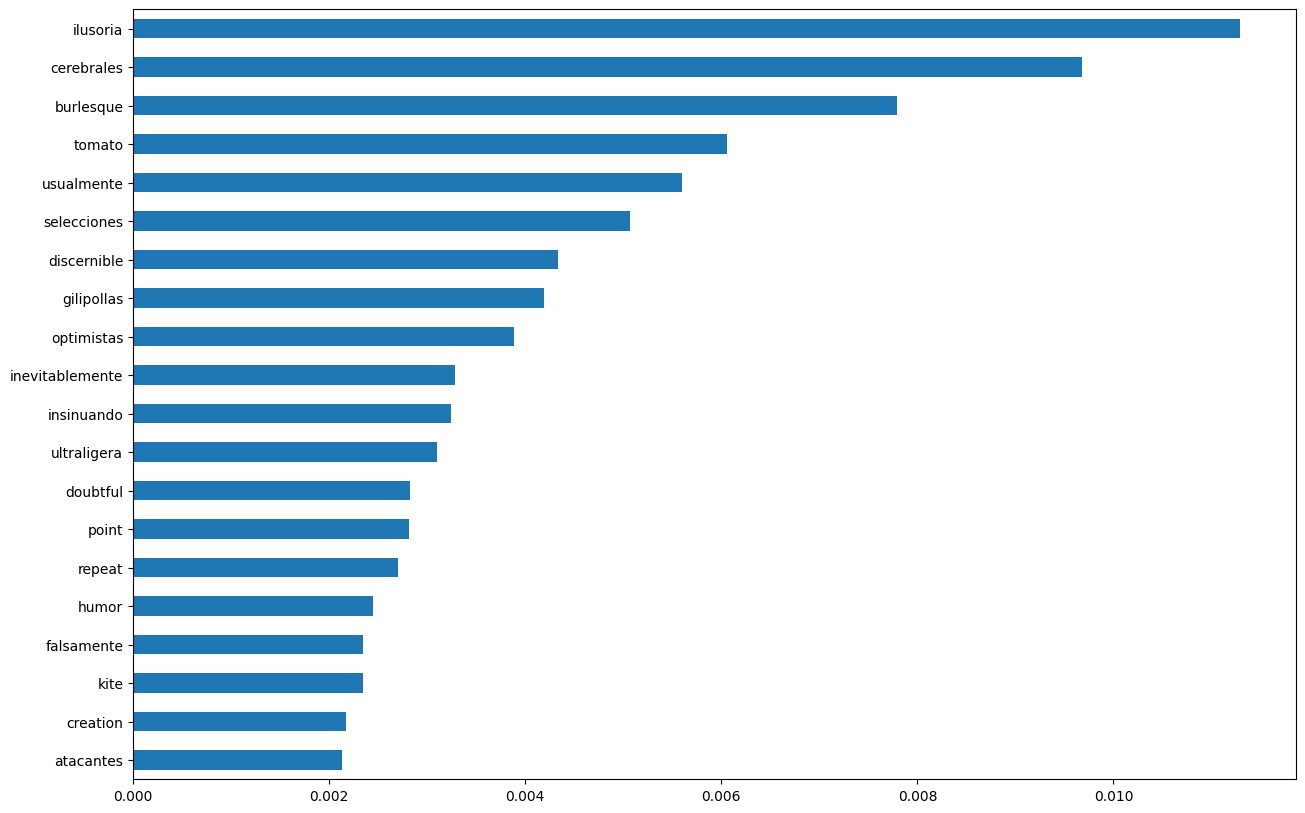

In [ ]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 198.46


In [ ]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

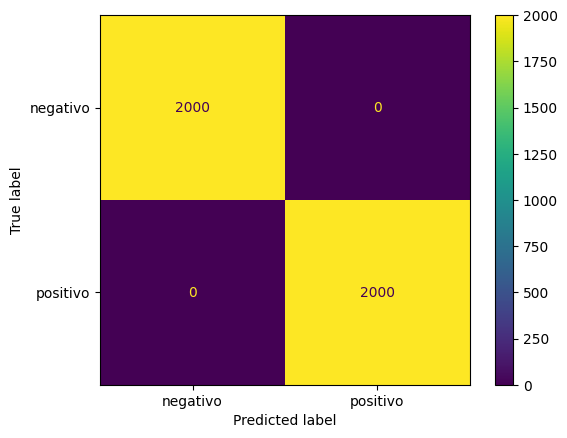

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

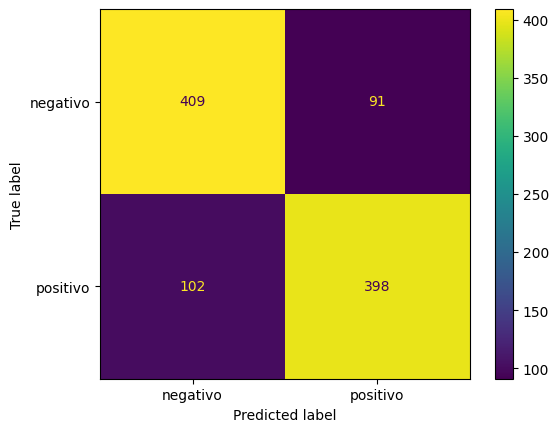

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [ ]:
pd.DataFrame([
    {
        'Train': precision_score(y_train, y_train_bow_predict, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_test_bow_predict, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, y_train_bow_predict, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_test_bow_predict, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, y_train_bow_predict, pos_label = 'positivo'),
        'Test': f1_score(y_test, y_test_bow_predict, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,1.0,0.813906
Recall,1.0,0.796000
F1,1.0,0.804853


####Modelo Random Forest Classifier usado BoW - Mayor complejidad

In [ ]:
forest_model_bow = RandomForestClassifier(random_state = 2)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6], # Por lo general, en Random Forest no es necesario experimentar con profundidades altas comparativamente con los Decision Tree 
    'min_samples_split': [2, 3, 4, 5]
}

In [ ]:
combinations = 1
for k, v in param_grid.items():
    combinations *= len(v)

print('Total de combinaciones a validar:', combinations)

Total de combinaciones a validar: 128


In [ ]:
# En este caso se decide buscar solo sobre el ~33% de las combinaciones
bow_grid_forest_model = RandomizedSearchCV(forest_model_bow, param_grid, n_iter = int(combinations / 3), scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [ ]:
bow_grid_forest_model.fit(X_bow, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2),
                   n_iter=42, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [50, 100, 150, 200]},
                   refit='f1', scoring=['precision', 'recall', 'f1'],
                   verbose=1)

In [ ]:
cv_results_df = pd.DataFrame(bow_grid_forest_model.cv_results_)

In [ ]:
bow_grid_forest_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 4,
 'max_depth': 3,
 'criterion': 'entropy'}

In [ ]:
y_bow_preds_train = bow_grid_forest_model.best_estimator_.predict(X_bow)
y_bow_preds_test = bow_grid_forest_model.best_estimator_.predict(bow.transform(X_test))

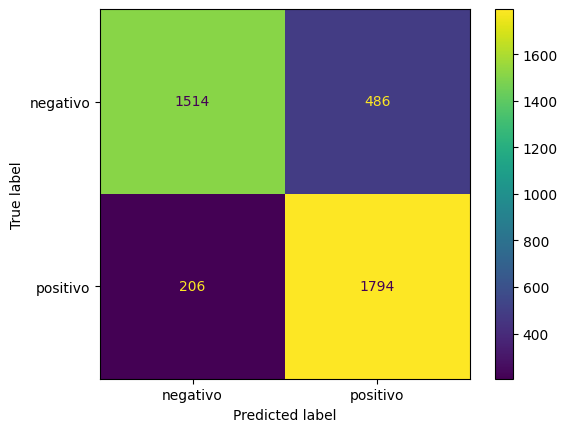

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_bow_preds_train)

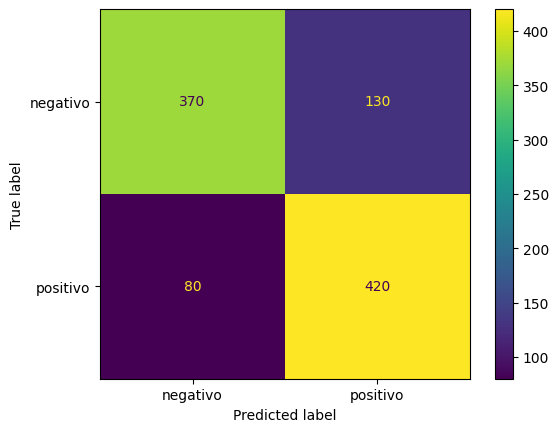

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_bow_preds_test)

In [ ]:
pd.DataFrame([
    {
        'Train': precision_score(y_train, y_bow_preds_train, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_bow_preds_test, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, y_bow_preds_train, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_bow_preds_test, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, y_bow_preds_train, pos_label = 'positivo'),
        'Test': f1_score(y_test, y_bow_preds_test, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,0.786842,0.763636
Recall,0.897000,0.840000
F1,0.838318,0.800000


####Modelo Random Forest Classifier usando TF-IDF

In [ ]:
tfidf_model = RandomForestClassifier(random_state = 4)

In [ ]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=4)

<Axes: >

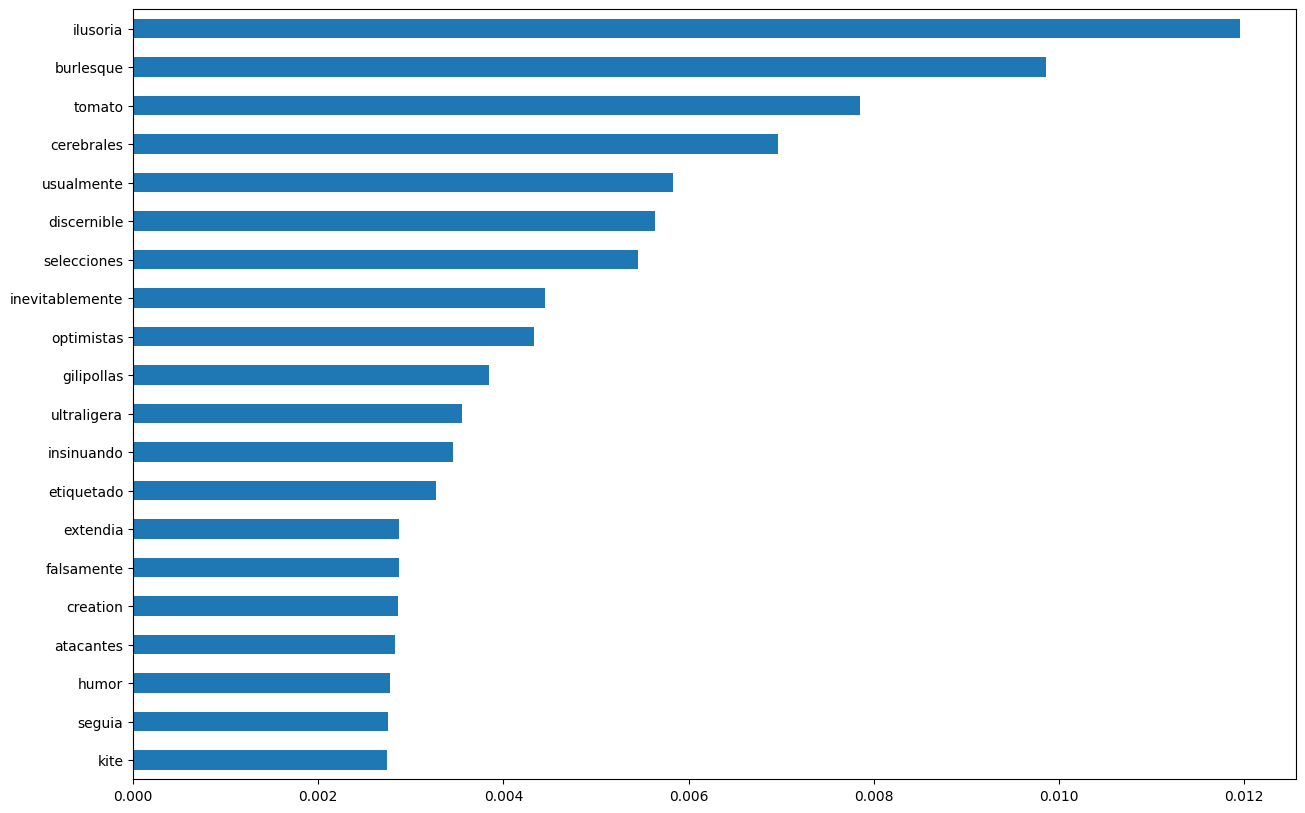

In [ ]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 176.11


In [ ]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

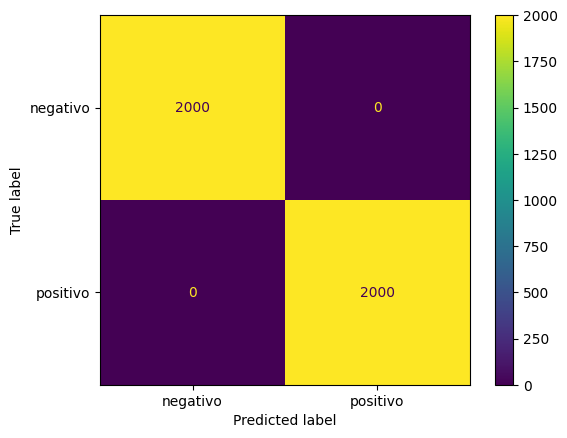

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

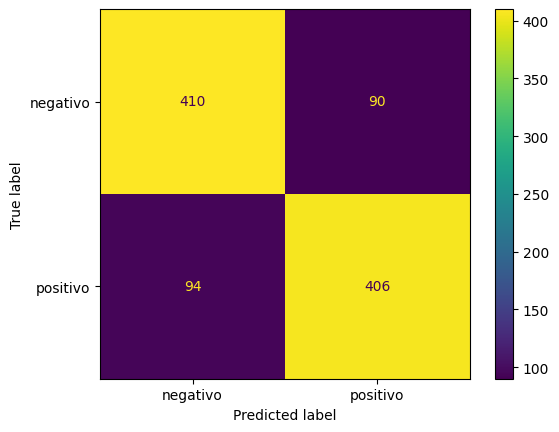

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [ ]:
pd.DataFrame([
    {
        'Train': precision_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, y_train_tfidf_predict, pos_label = 'positivo'),
        'Test': f1_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,1.0,0.818548
Recall,1.0,0.812000
F1,1.0,0.815261


####Modelo Random Forest Classifier usando TF-IDF - Mayor complejidad

In [ ]:
forest_model_tfidf = RandomForestClassifier(random_state = 2)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6], # Por lo general, en Random Forest no es necesario experimentar con profundidades altas comparativamente con los Decision Tree 
    'min_samples_split': [2, 3, 4, 5]
}

In [ ]:
combinations = 1
for k, v in param_grid.items():
    combinations *= len(v)

print('Total de combinaciones a validar:', combinations)

Total de combinaciones a validar: 128


In [ ]:
# En este caso se decide buscar solo sobre el ~33% de las combinaciones
tfidf_grid_forest_model = RandomizedSearchCV(forest_model_tfidf, param_grid, n_iter = int(combinations / 3), scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, n_jobs = -1, verbose = 1)

In [ ]:
tfidf_grid_forest_model.fit(X_tfidf, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2),
                   n_iter=42, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [50, 100, 150, 200]},
                   refit='f1', scoring=['precision', 'recall', 'f1'],
                   verbose=1)

In [ ]:
cv_results_df = pd.DataFrame(tfidf_grid_forest_model.cv_results_)

In [ ]:
tfidf_grid_forest_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'max_depth': 5,
 'criterion': 'gini'}

In [ ]:
y_tfidf_preds_train = tfidf_grid_forest_model.best_estimator_.predict(X_tfidf)
y_tfidf_preds_test = tfidf_grid_forest_model.best_estimator_.predict(tfidf.transform(X_test))

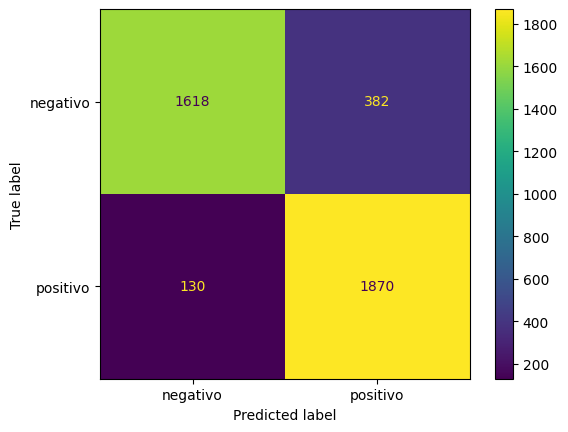

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_tfidf_preds_train)

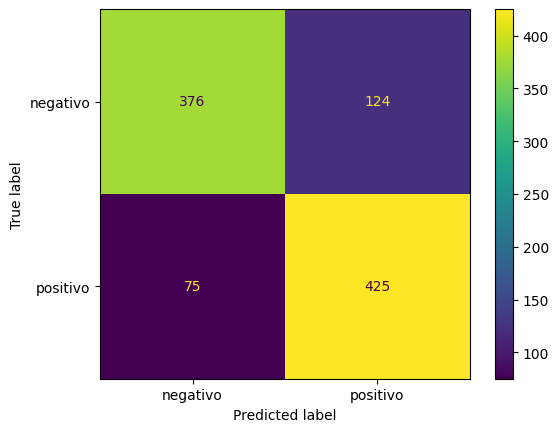

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_tfidf_preds_test)

In [ ]:
pd.DataFrame([
    {
        'Train': precision_score(y_train, y_tfidf_preds_train, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_tfidf_preds_test, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, y_tfidf_preds_train, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_tfidf_preds_test, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, y_tfidf_preds_train, pos_label = 'positivo'),
        'Test': f1_score(y_test, y_tfidf_preds_test, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,0.830373,0.774135
Recall,0.935000,0.850000
F1,0.879586,0.810296


## Algortimo Arboles de Decisión - Erich

### Entrenamiento Arbol de desición con BoW

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40],
    'min_samples_split': [2, 3, 4, 5]
}

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2,100)if i%2 == 0],
    'min_samples_split': [i for i in range(2,30)if i%2 == 0]
}
f1=0
precision=0.6
model=0
model_precition=0
max_f1_depth=0
max_f1_criterion=0
max_f1_min_samples_split=0
max_prec_depth=0
max_prec_criterion=0
max_prec_min_samples_split=0
for max_depthp in param_grid['max_depth']:
    for criterionp in param_grid['criterion']:
        for min_samples_splitp in param_grid['min_samples_split']:
            tree_model = DecisionTreeClassifier(criterion=criterionp,max_depth = max_depthp, random_state = 1, min_samples_split=min_samples_splitp)
            tree_model.fit(X_bow, y_train)
            preds_train = tree_model.predict(X_bow)
            preds_test = tree_model.predict(tfidf.transform(X_test))
            if len(bow_model.classes_) == 2:
                if precision_score(y_test, preds_test, pos_label = 'positivo')>precision:
                    print("PREEEEEEE", precision_score(y_test, preds_test, pos_label = 'positivo'))
                    precision=precision_score(y_test, preds_test, pos_label = 'positivo')
                    model_precition=tree_model
                    max_prec_depth=max_depthp
                    max_prec_criterion=criterionp
                    max_prec_min_samples_split=min_samples_splitp
                if f1_score(y_test, preds_test, pos_label = 'positivo')>f1:
                    f1=f1_score(y_test, preds_test, pos_label = 'positivo')
                    model=tree_model
                    max_f1_depth=max_depthp
                    max_f1_criterion=criterionp
                    max_f1_min_samples_split=min_samples_splitp
                    print("training")
                    print('Precision:', precision_score(y_train, preds_train, pos_label = 'positivo'))
                    print('Recall:', recall_score(y_train, preds_train, pos_label = 'positivo'))
                    print('F1:', f1_score(y_train, preds_train, pos_label = 'positivo'))
                    print("test")
                    print('Precision:', precision_score(y_test, preds_test, pos_label = 'positivo'))
                    print('Recall:', recall_score(y_test, preds_test, pos_label = 'positivo'))
                    print('F1:', f1_score(y_test, preds_test, pos_label = 'positivo'))
            else:
                if precision_score(y_test, preds_test, average = None)>precision:
                    print("PREEEEEEE", precision_score(y_test, preds_test, average = None))
                    precision=precision_score(y_test, preds_test, average = None)
                    model_precition=tree_model
                    max_prec_depth=max_depthp
                    max_prec_criterion=criterionp
                    max_prec_min_samples_split=min_samples_splitp
                if f1_score(y_test, preds_test, average = None)>f1:
                    f1=f1_score(y_test, preds_test, average = None)
                    model=tree_model
                    max_f1_depth=max_depthp
                    max_f1_criterion=criterionp
                    max_f1_min_samples_split=min_samples_splitp
                    print("training")
                    print('Precision:', precision_score(y_train, preds_train, average = None))
                    print('Recall:', recall_score(y_train, preds_train, average = None))
                    print('F1:', f1_score(y_train, preds_train, average = None))
                    print("test")
                    print('Precision:', precision_score(y_test, preds_test, average = None))
                    print('Recall:', recall_score(y_test, preds_test, average = None))
                    print('F1:', f1_score(y_test, preds_test, average = None))

In [ ]:
preds_train = model.predict(X_bow)
preds_test = model.predict(bow.transform(X_test))
print("training")
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, preds_train, pos_label = 'positivo'))
    print('Recall:', recall_score(y_train, preds_train, pos_label = 'positivo'))
    print('F1:', f1_score(y_train, preds_train, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, preds_train, average = None))
    print('Recall:', recall_score(y_train, preds_train, average = None))
    print('F1:', f1_score(y_train, preds_train, average = None))
print("test")
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, preds_test, pos_label = 'positivo'))
    print('Recall:', recall_score(y_test, preds_test, pos_label = 'positivo'))
    print('F1:', f1_score(y_test, preds_test, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, preds_test, average = None))
    print('Recall:', recall_score(y_test, preds_test, average = None))
    print('F1:', f1_score(y_test, preds_test, average = None))


Dado que se demora mucho en dar un resultaod, corremos el optimo de una vez.

In [ ]:
model_x = DecisionTreeClassifier(criterion="gini",max_depth = 6, random_state = 1, min_samples_split=20)
model_x.fit(X_bow, y_train)
preds_train = model_x.predict(X_bow)
preds_test = model_x.predict(bow.transform(X_test))
print("training")
print(len(bow_model.classes_))
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, preds_train, pos_label = 'positivo'))
    print('Recall:', recall_score(y_train, preds_train, pos_label = 'positivo'))
    print('F1:', f1_score(y_train, preds_train, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, preds_train, average = None))
    print('Recall:', recall_score(y_train, preds_train, average = None))
    print('F1:', f1_score(y_train, preds_train, average = None))
print("test")
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, preds_test, pos_label = 'positivo'))
    print('Recall:', recall_score(y_test, preds_test, pos_label = 'positivo'))
    print('F1:', f1_score(y_test, preds_test, pos_label = 'positivo'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, preds_test, average = None))
    print('Recall:', recall_score(y_test, preds_test, average = None))
    print('F1:', f1_score(y_test, preds_test, average = None))

training
2
Precision: 0.6325985303941216
Recall: 0.947
F1: 0.7585102122547056
test
Precision: 0.6117804551539491
Recall: 0.914
F1: 0.7329591018444266


<Axes: >

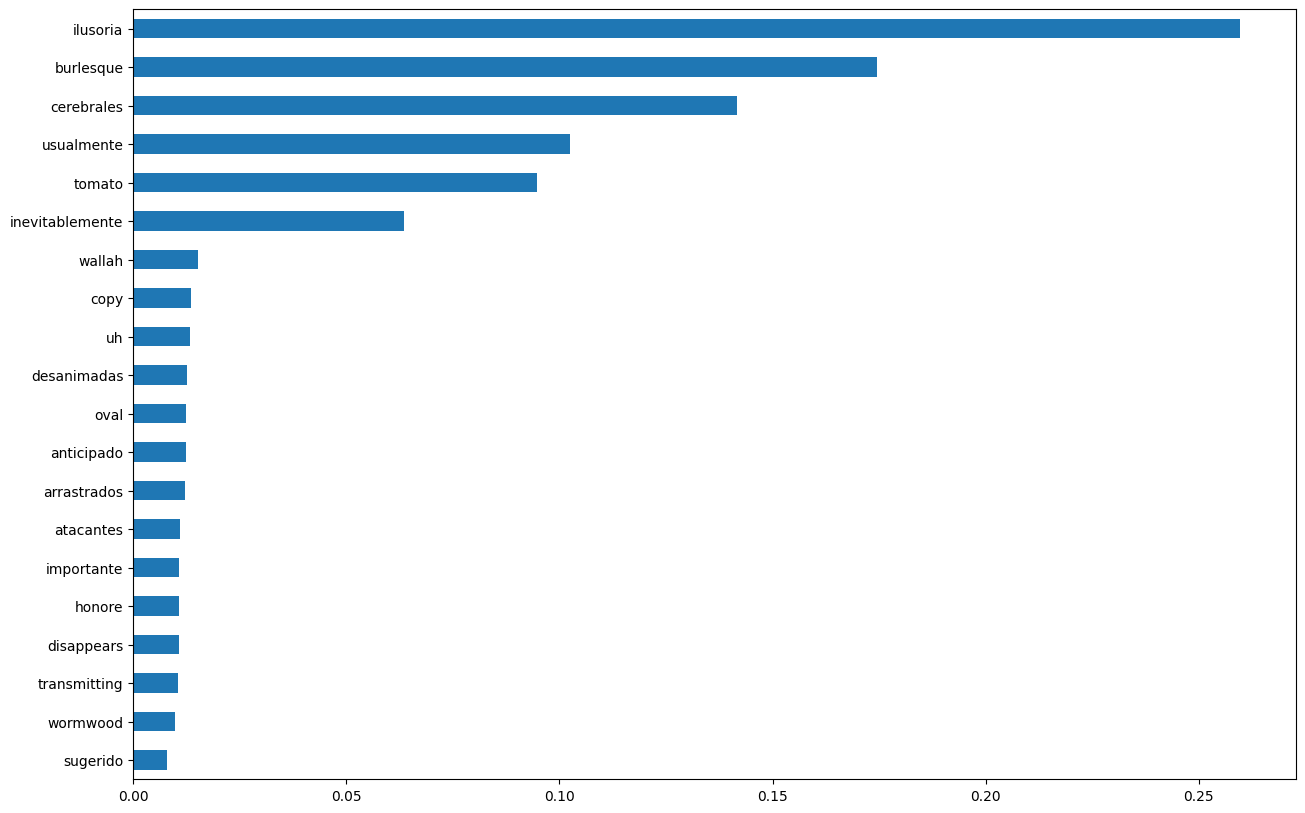

In [ ]:
pd.Series(model_x.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))


### Entrenamiento Arbol de desición con TF-IDF

In [ ]:
model_tf_idf_dt = DecisionTreeClassifier(criterion="gini",max_depth = "6", random_state = 1, min_samples_split="20")
model_tf_idf_dt.fit(X_tfidf, y_train)

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(2,100)if i%2 == 0],
    'min_samples_split': [i for i in range(2,30)if i%2 == 0]
}
f1=0
precision=0.6
model=0
model_precition=0
max_f1_depth=0
max_f1_criterion=0
max_f1_min_samples_split=0
max_prec_depth=0
max_prec_criterion=0
max_prec_min_samples_split=0
for max_depthp in param_grid['max_depth']:
    for criterionp in param_grid['criterion']:
        for min_samples_splitp in param_grid['min_samples_split']:
            tree_model = DecisionTreeClassifier(criterion=criterionp,max_depth = max_depthp, random_state = 1, min_samples_split=min_samples_splitp)
            tree_model.fit(X_tfidf, y_train)
            preds_train = tree_model.predict(X_tfidf)
            preds_test = tree_model.predict(bow.transform(X_test))
            if len(bow_model.classes_) == 2:
                if precision_score(y_test, preds_test, pos_label = 'positivo')>precision:
                    print("PREEEEEEE", precision_score(y_test, preds_test, pos_label = 'positivo'))
                    precision=precision_score(y_test, preds_test, pos_label = 'positivo')
                    model_precition=tree_model
                    max_prec_depth=max_depthp
                    max_prec_criterion=criterionp
                    max_prec_min_samples_split=min_samples_splitp
                if f1_score(y_test, preds_test, pos_label = 'positivo')>f1:
                    f1=f1_score(y_test, preds_test, pos_label = 'positivo')
                    model=tree_model
                    max_f1_depth=max_depthp
                    max_f1_criterion=criterionp
                    max_f1_min_samples_split=min_samples_splitp
                    print("training")
                    print('Precision:', precision_score(y_train, preds_train, pos_label = 'positivo'))
                    print('Recall:', recall_score(y_train, preds_train, pos_label = 'positivo'))
                    print('F1:', f1_score(y_train, preds_train, pos_label = 'positivo'))
                    print("test")
                    print('Precision:', precision_score(y_test, preds_test, pos_label = 'positivo'))
                    print('Recall:', recall_score(y_test, preds_test, pos_label = 'positivo'))
                    print('F1:', f1_score(y_test, preds_test, pos_label = 'positivo'))
            else:
                if precision_score(y_test, preds_test, average = None)>precision:
                    print("PREEEEEEE", precision_score(y_test, preds_test, average = None))
                    precision=precision_score(y_test, preds_test, average = None)
                    model_precition=tree_model
                    max_prec_depth=max_depthp
                    max_prec_criterion=criterionp
                    max_prec_min_samples_split=min_samples_splitp
                if f1_score(y_test, preds_test, average = None)>f1:
                    f1=f1_score(y_test, preds_test, average = None)
                    model=tree_model
                    max_f1_depth=max_depthp
                    max_f1_criterion=criterionp
                    max_f1_min_samples_split=min_samples_splitp
                    print("training")
                    print('Precision:', precision_score(y_train, preds_train, average = None))
                    print('Recall:', recall_score(y_train, preds_train, average = None))
                    print('F1:', f1_score(y_train, preds_train, average = None))
                    print("test")
                    print('Precision:', precision_score(y_test, preds_test, average = None))
                    print('Recall:', recall_score(y_test, preds_test, average = None))
                    print('F1:', f1_score(y_test, preds_test, average = None))

training
Precision: 0.5695383710673332
Recall: 0.9685
F1: 0.7172745787817072
test
Precision: 0.5707376058041113
Recall: 0.944
F1: 0.7113790504898267
PREEEEEEE 0.6117804551539491
training
Precision: 0.613855035279025
Recall: 0.957
F1: 0.7479484173505275
test
Precision: 0.6117804551539491
Recall: 0.914
F1: 0.7329591018444266
PREEEEEEE 0.6244725738396625
training
Precision: 0.6653557382910261
Recall: 0.9305
F1: 0.7759016051698978
test
Precision: 0.6244725738396625
Recall: 0.888
F1: 0.7332782824112305
training
Precision: 0.6621380050053629
Recall: 0.926
F1: 0.772149259954138
test
Precision: 0.6241234221598878
Recall: 0.89
F1: 0.7337180544105524
PREEEEEEE 0.648881239242685
PREEEEEEE 0.6512027491408935
PREEEEEEE 0.6631762652705061
PREEEEEEE 0.6637478108581436
PREEEEEEE 0.6696269982238011
PREEEEEEE 0.6748582230623819
PREEEEEEE 0.6805293005671077
PREEEEEEE 0.6844106463878327
PREEEEEEE 0.6868475991649269
PREEEEEEE 0.6871035940803383
PREEEEEEE 0.6965065502183406
PREEEEEEE 0.7
PREEEEEEE 0.7018779

In [ ]:
preds_train = model.predict(X_tfidf)
preds_test = model.predict(tfidf.transform(X_test))
pd.DataFrame([
    {
        'Train': precision_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': f1_score(y_test, preds_test, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,0.662138,0.818548
Recall,0.926000,0.812000
F1,0.772149,0.736402


In [ ]:
print(max_f1_depth)
print(max_f1_criterion)
print(max_f1_min_samples_split)
print(max_prec_depth)
print(max_prec_criterion)
print(max_prec_min_samples_split)

8
entropy
14
92
entropy
24


In [ ]:
preds_train = model_precition.predict(X_tfidf)
preds_test = model_precition.predict(tfidf.transform(X_test))
pd.DataFrame([
    {
        'Train': precision_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_test_tfidf_predict, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, preds_train, pos_label = 'positivo'),
        'Test': f1_score(y_test, preds_test, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,0.955178,0.818548
Recall,0.927000,0.812000
F1,0.940878,0.700599


<Axes: >

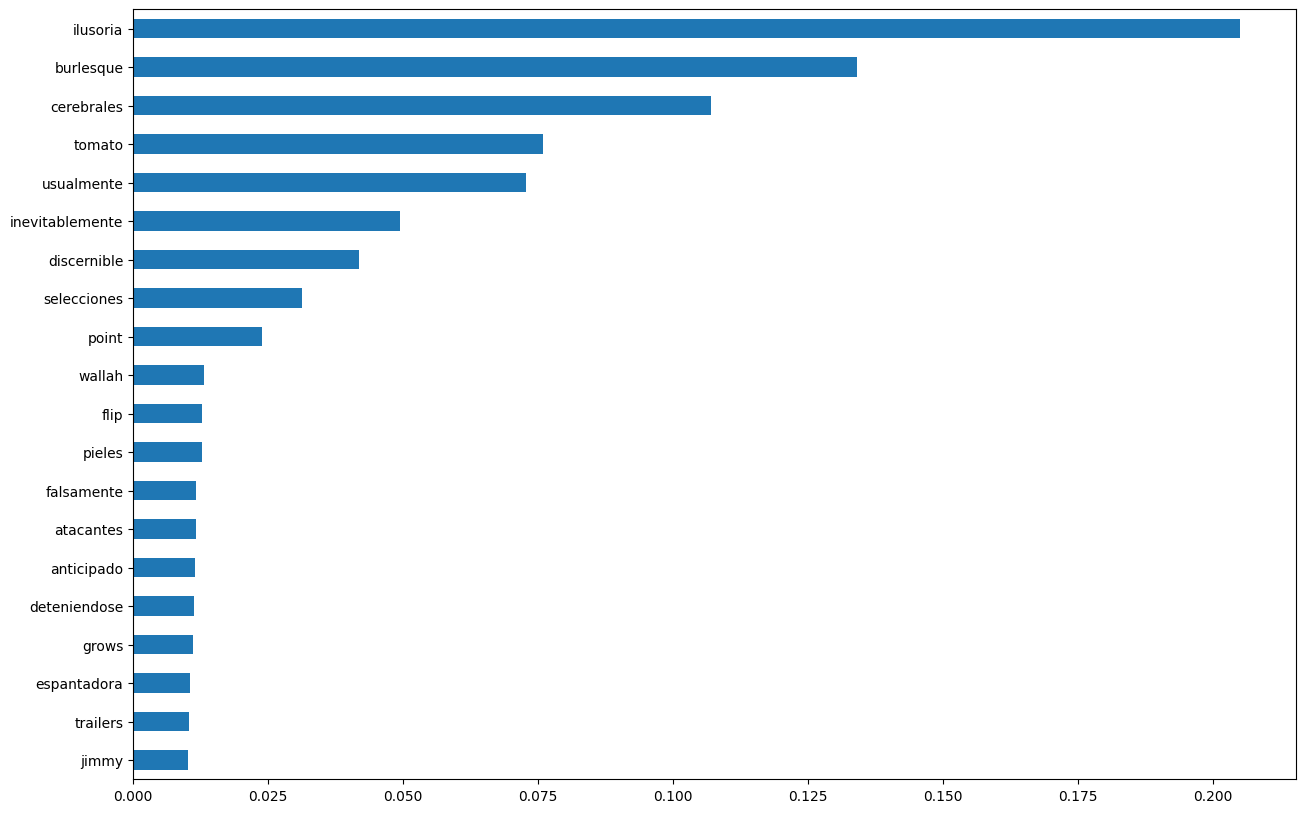

In [ ]:
pd.Series(model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

<Axes: >

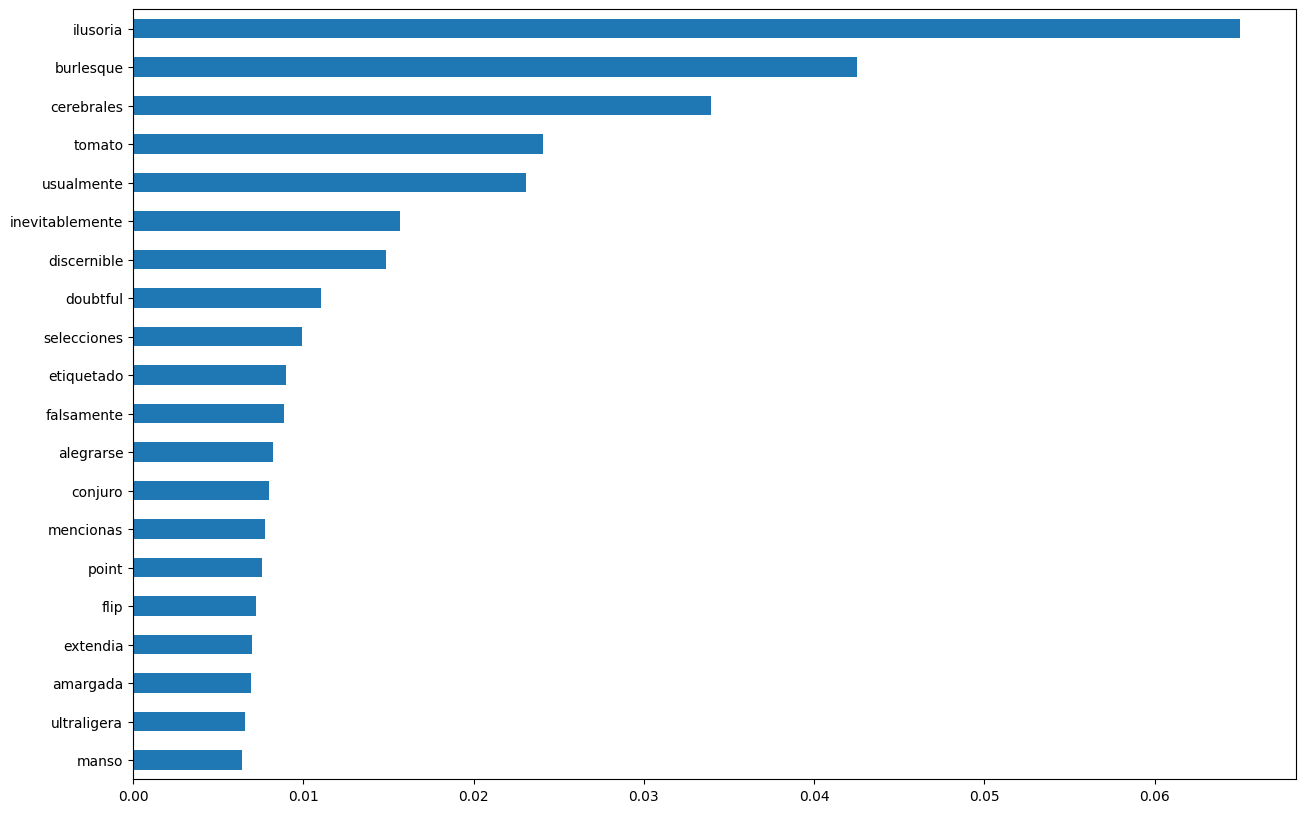

In [ ]:
pd.Series(model_precition.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

## Algoritmo SVM - Juan Esteban Rodríguez



In [ ]:
X_tfidf_2 = tfidf.fit_transform(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
classifer = SVC(kernel = 'linear', random_state = 0)
classifer.fit(X_tfidf_2,y_train)

SVC(kernel='linear', random_state=0)

In [ ]:
y_pred = classifer.predict(tfidf.transform(X_test))
y_t = classifer.predict(tfidf.transform(X_train))

###Matriz de Confusión

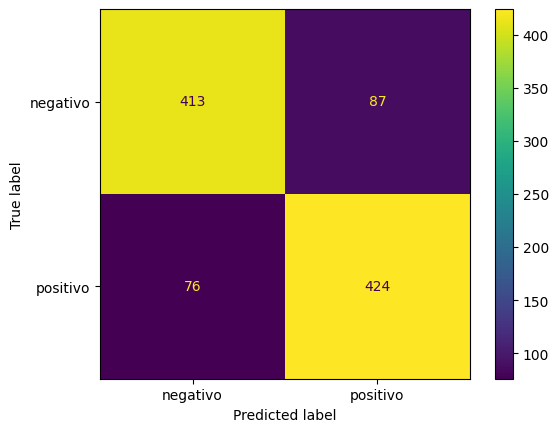

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

In [ ]:

pd.DataFrame([
    {
        'Train': precision_score(y_train, y_t, pos_label = 'positivo'),
        'Test': precision_score(y_test, y_pred, pos_label = 'positivo')
    },
    {
        'Train':recall_score(y_train, y_t, pos_label = 'positivo'),
        'Test': recall_score(y_test, y_pred, pos_label = 'positivo')
    },
    {
        'Train': f1_score(y_train, y_t, pos_label = 'positivo'),
        'Test': f1_score(y_test, y_pred, pos_label = 'positivo')
    }
], index = ['Precision', 'Recall', 'F1'])

,Train,Test
Precision,0.987562,0.829746
Recall,0.992500,0.848000
F1,0.990025,0.838773
